In [2]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

df = pd.read_csv('AAPL (4) (3).csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (2011, 7)

First 5 rows:
         Date       Open       High        Low      Close  Adj Close    Volume
0  03-01-2012  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1  04-01-2012  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2  05-01-2012  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3  06-01-2012  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4  09-01-2012  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Open       2011 non-null   float64
 2   High       2011 non-null   float64
 3   Low        2011 non-null   float64
 4   Close      2011 non-null   float64
 5   Adj Close  2011 non-null   float64
 6   Volume     2011 non-null   int64  
dtype

In [4]:
# =============================================================================
# DATA PREPROCESSING
# =============================================================================

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)

print("Duplicate rows:", df.duplicated().sum())
print("Cleaned Dataset Info:")
print(df.info())

Duplicate rows: 0
Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2011 entries, 2012-01-03 to 2019-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2011 non-null   float64
 1   High       2011 non-null   float64
 2   Low        2011 non-null   float64
 3   Close      2011 non-null   float64
 4   Adj Close  2011 non-null   float64
 5   Volume     2011 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 110.0 KB
None


In [5]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

def create_features(data):
    df_features = data.copy()

    df_features['Price_Range'] = df_features['High'] - df_features['Low']
    df_features['Price_Change'] = df_features['Close'] - df_features['Open']
    df_features['Price_Change_Pct'] = (df_features['Close'] - df_features['Open']) / df_features['Open'] * 100

    df_features['MA_5'] = df_features['Close'].rolling(window=5).mean()
    df_features['MA_10'] = df_features['Close'].rolling(window=10).mean()
    df_features['MA_20'] = df_features['Close'].rolling(window=20).mean()
    df_features['MA_50'] = df_features['Close'].rolling(window=50).mean()

    df_features['Volatility_5'] = df_features['Close'].rolling(window=5).std()
    df_features['Volatility_10'] = df_features['Close'].rolling(window=10).std()

    delta = df_features['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_features['RSI'] = 100 - (100 / (1 + rs))

    exp1 = df_features['Close'].ewm(span=12).mean()
    exp2 = df_features['Close'].ewm(span=26).mean()
    df_features['MACD'] = exp1 - exp2
    df_features['MACD_Signal'] = df_features['MACD'].ewm(span=9).mean()

    df_features['Volume_MA_5'] = df_features['Volume'].rolling(window=5).mean()
    df_features['Volume_Change'] = df_features['Volume'].pct_change()

    for lag in [1, 2, 3, 5, 10]:
        df_features[f'Close_Lag_{lag}'] = df_features['Close'].shift(lag)

    df_features['Target_30d'] = df_features['Close'].shift(-30)

    return df_features

df_enhanced = create_features(df)
print("Enhanced dataset shape:", df_enhanced.shape)

df_enhanced = df_enhanced.dropna()
print("Final dataset shape after cleaning:", df_enhanced.shape)
print("Remaining missing values:", df_enhanced.isnull().sum().sum())

Enhanced dataset shape: (2011, 26)
Final dataset shape after cleaning: (1932, 26)
Remaining missing values: 0


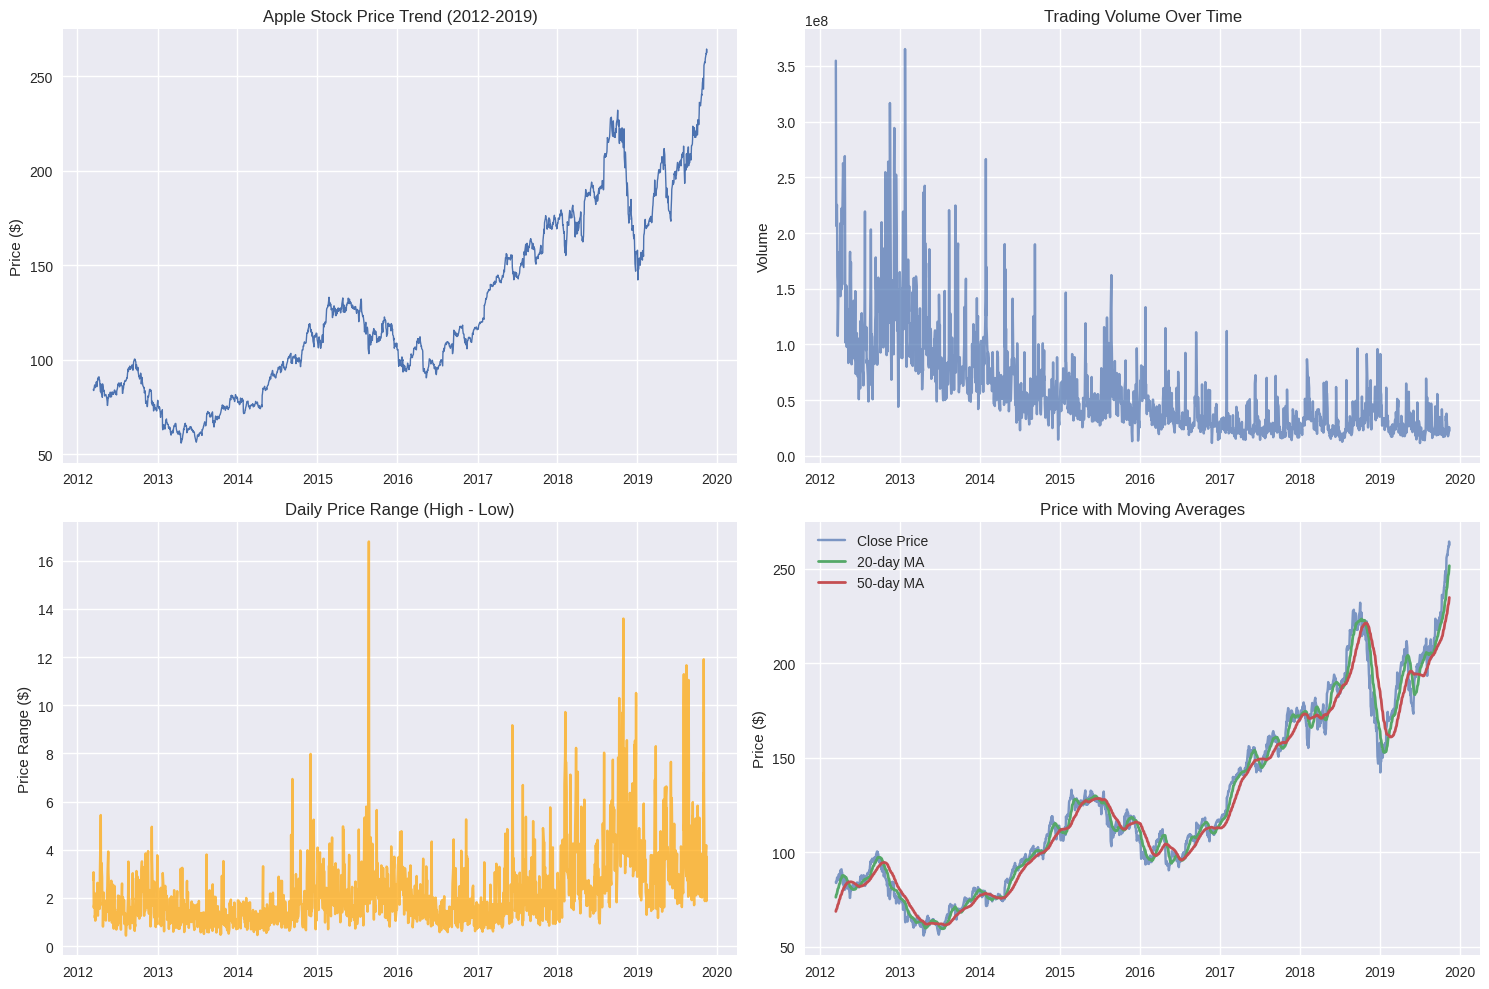

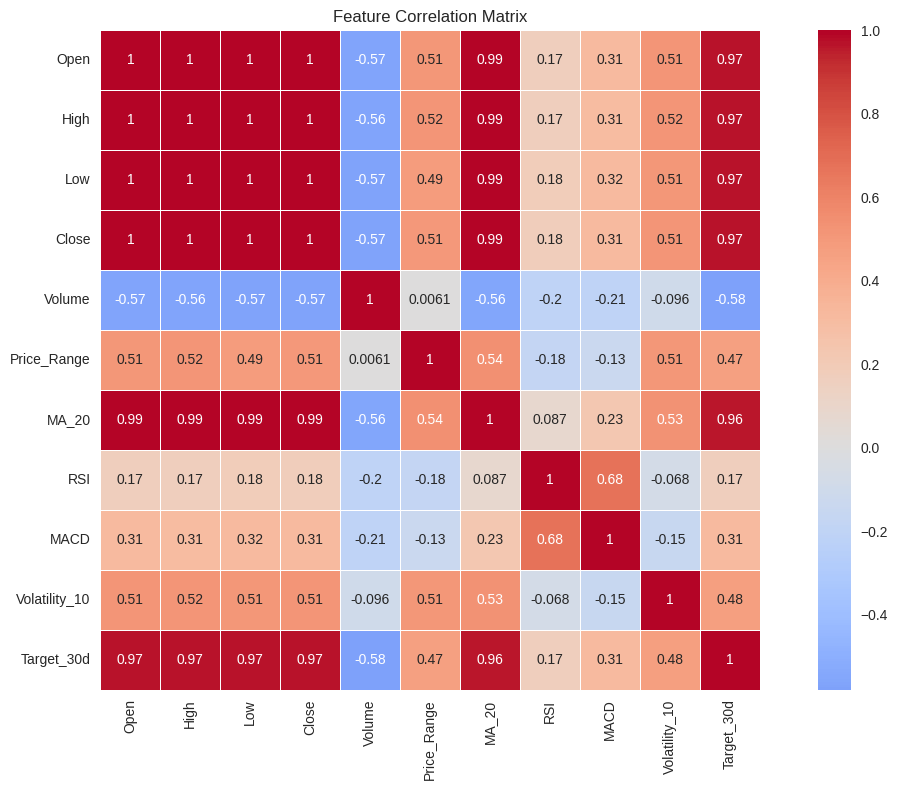

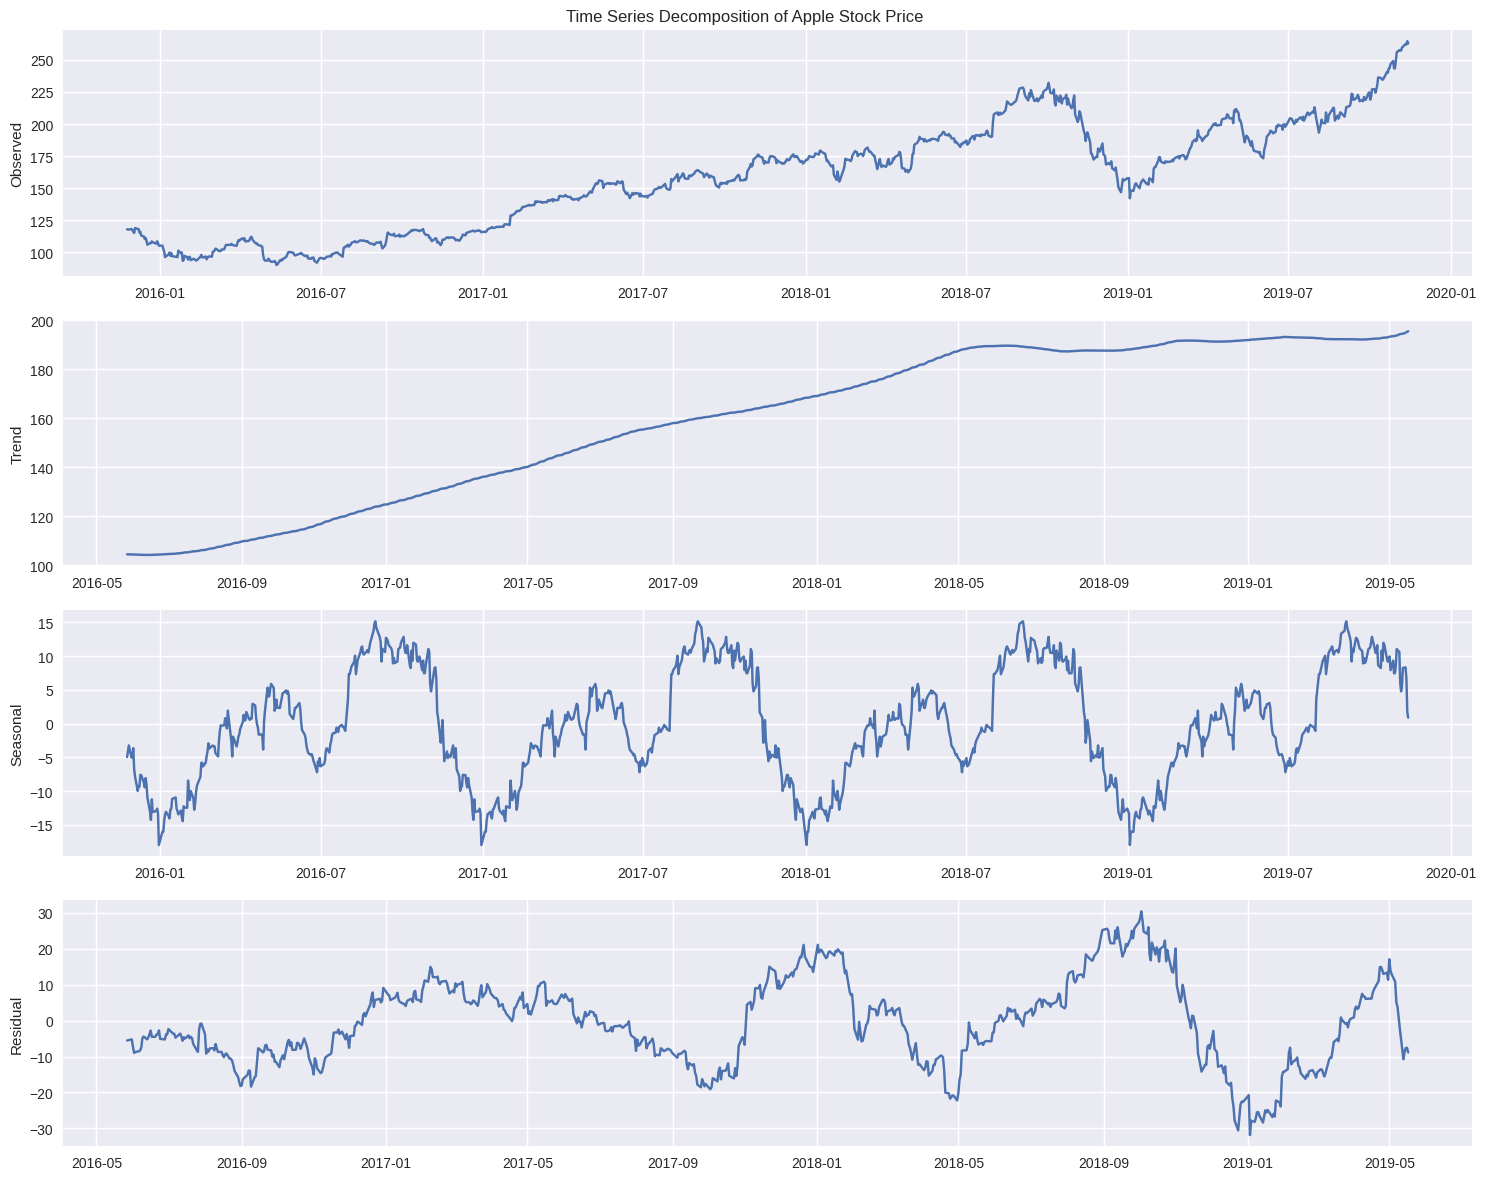

Stationarity check for Close prices:
ADF Statistic: 0.803677
p-value: 0.991695
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Series is not stationary


In [6]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(df_enhanced.index, df_enhanced['Close'], linewidth=1)
axes[0, 0].set_title('Apple Stock Price Trend (2012-2019)')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True)

axes[0, 1].plot(df_enhanced.index, df_enhanced['Volume'], alpha=0.7)
axes[0, 1].set_title('Trading Volume Over Time')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].grid(True)

axes[1, 0].plot(df_enhanced.index, df_enhanced['Price_Range'], alpha=0.7, color='orange')
axes[1, 0].set_title('Daily Price Range (High - Low)')
axes[1, 0].set_ylabel('Price Range ($)')
axes[1, 0].grid(True)

axes[1, 1].plot(df_enhanced.index, df_enhanced['Close'], label='Close Price', alpha=0.7)
axes[1, 1].plot(df_enhanced.index, df_enhanced['MA_20'], label='20-day MA', linewidth=2)
axes[1, 1].plot(df_enhanced.index, df_enhanced['MA_50'], label='50-day MA', linewidth=2)
axes[1, 1].set_title('Price with Moving Averages')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
correlation_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price_Range',
                   'MA_20', 'RSI', 'MACD', 'Volatility_10', 'Target_30d']
corr_matrix = df_enhanced[correlation_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

decomposition = seasonal_decompose(df_enhanced['Close'].iloc[-1000:],
                                 period=252,
                                 model='additive')

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

axes[0].plot(decomposition.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomposition.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomposition.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomposition.resid)
axes[3].set_ylabel('Residual')

plt.suptitle('Time Series Decomposition of Apple Stock Price')
plt.tight_layout()
plt.show()

def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

print("Stationarity check for Close prices:")
check_stationarity(df_enhanced['Close'])

In [7]:
# =============================================================================
# FEATURE PREPARATION FOR MACHINE LEARNING
# =============================================================================

feature_columns = [col for col in df_enhanced.columns if col not in
                  ['Target_30d', 'Adj Close'] and not col.startswith('Close_Lag')]

lag_features = ['Close_Lag_1', 'Close_Lag_2', 'Close_Lag_5']
feature_columns.extend(lag_features)

X = df_enhanced[feature_columns]
y = df_enhanced['Target_30d']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

X_train_tree = X_train.copy()
X_test_tree = X_test.copy()

Feature matrix shape: (1932, 22)
Target vector shape: (1932,)
Training set: (1545, 22)
Testing set: (387, 22)


Time Series Train: (1545,)
Time Series Test: (387,)


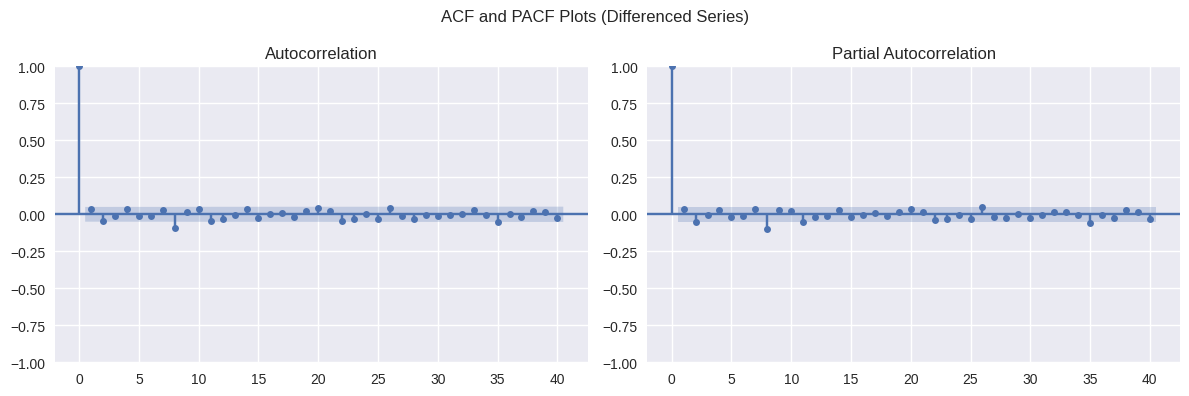

Training ARIMA model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1545
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2963.068
Date:                Wed, 08 Oct 2025   AIC                           5936.135
Time:                        05:07:19   BIC                           5962.846
Sample:                             0   HQIC                          5946.072
                               - 1545                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0685      0.077    -13.914      0.000      -1.219      -0.918
ar.L2         -0.8002      0.065    -12.353      0.000      -0.927      -0.673
ma.L1          1.1288      0.073     15.439      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [8]:
# =============================================================================
# ARIMA MODEL
# =============================================================================

ts_data = df_enhanced['Close']
ts_train = ts_data.iloc[:split_index]
ts_test = ts_data.iloc[split_index:]

print(f"Time Series Train: {ts_train.shape}")
print(f"Time Series Test: {ts_test.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(ts_train.diff().dropna(), ax=axes[0], lags=40)
plot_pacf(ts_train.diff().dropna(), ax=axes[1], lags=40)
plt.suptitle('ACF and PACF Plots (Differenced Series)')
plt.tight_layout()
plt.show()

print("Training ARIMA model...")
results = {}

try:
    arima_model = ARIMA(ts_train, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    print(arima_fit.summary())

    arima_forecast = arima_fit.forecast(steps=len(ts_test))
    arima_mae = mean_absolute_error(ts_test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(ts_test, arima_forecast))
    arima_r2 = r2_score(ts_test, arima_forecast)

    print(f"ARIMA MAE: ${arima_mae:.2f}")
    print(f"ARIMA RMSE: ${arima_rmse:.2f}")
    print(f"ARIMA R²: {arima_r2:.4f}")

    results['ARIMA'] = {
        'model': arima_fit,
        'predictions': arima_forecast,
        'mae': arima_mae,
        'rmse': arima_rmse,
        'r2': arima_r2
    }

except Exception as e:
    print(f"ARIMA model failed: {e}")

In [9]:
# =============================================================================
# SARIMA MODEL
# =============================================================================

print("Training SARIMA model...")
try:
    sarima_model = SARIMAX(ts_train,
                         order=(1, 1, 1),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

    sarima_fit = sarima_model.fit(disp=False)
    print(sarima_fit.summary())

    sarima_forecast = sarima_fit.forecast(steps=len(ts_test))
    sarima_mae = mean_absolute_error(ts_test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(ts_test, sarima_forecast))
    sarima_r2 = r2_score(ts_test, sarima_forecast)

    print(f"SARIMA MAE: ${sarima_mae:.2f}")
    print(f"SARIMA RMSE: ${sarima_rmse:.2f}")
    print(f"SARIMA R²: {sarima_r2:.4f}")

    results['SARIMA'] = {
        'model': sarima_fit,
        'predictions': sarima_forecast,
        'mae': sarima_mae,
        'rmse': sarima_rmse,
        'r2': sarima_r2
    }

except Exception as e:
    print(f"SARIMA model failed: {e}")

Training SARIMA model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 1545
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2947.650
Date:                            Wed, 08 Oct 2025   AIC                           5905.300
Time:                                    05:07:32   BIC                           5931.926
Sample:                                         0   HQIC                          5915.213
                                           - 1545                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3867      0.449     -0.862      0.389      -1.266       0.492
ma.L1          0.4273      0.443   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Training XGBoost model...
XGBoost MAE: $38.18
XGBoost RMSE: $46.96
XGBoost R²: -1.3792


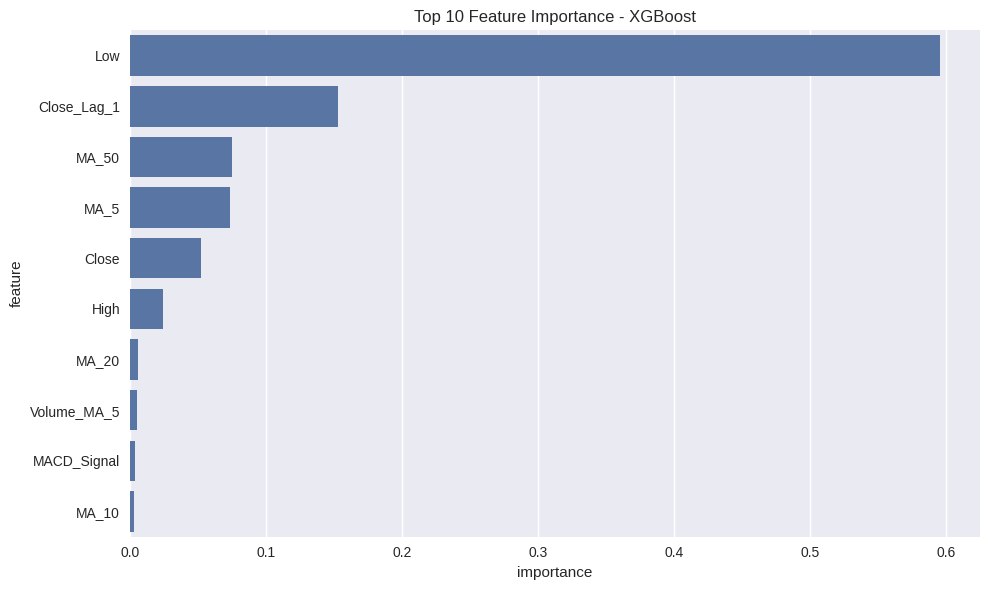

In [10]:
# =============================================================================
# XGBOOST MODEL
# =============================================================================

print("Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_tree, y_train)
xgb_predictions = xgb_model.predict(X_test_tree)

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost MAE: ${xgb_mae:.2f}")
print(f"XGBoost RMSE: ${xgb_rmse:.2f}")
print(f"XGBoost R²: {xgb_r2:.4f}")

results['XGBoost'] = {
    'model': xgb_model,
    'predictions': xgb_predictions,
    'mae': xgb_mae,
    'rmse': xgb_rmse,
    'r2': xgb_r2
}

xgb_feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance - XGBoost')
plt.tight_layout()
plt.show()

LSTM Training set: (1497, 60, 1)
LSTM Testing set: (375, 60, 1)
LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,701 (596.49 KB)

 Trainable params: 152,701 (596.49 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 0.0073 - mae: 0.0733 - val_loss: 0.0249 - val_mae: 0.1367
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.0216 - mae: 0.1328 - val_loss: 0.0123 - val_mae: 0.0960
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.0307 - mae: 0.1530 - val_loss: 0.0271 - val_mae: 0.1427
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0192 - mae: 0.1228 - val_loss: 0.0068 - val_mae: 0.0655
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.0257 - mae: 0.1389 - val_loss: 0.0126 - val_mae: 0.0909
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 0.0109 - mae: 0.0910 - val_loss: 0.0059 - val_mae: 0.0599
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0083 - mae: 0.0712 - val_loss: 0.0045 - val_mae: 0.0519
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0042 - mae: 0.0546 - val_loss: 0.0041 - val_mae: 0.0524
Epoch 9/100
47/47 ━━━━━━

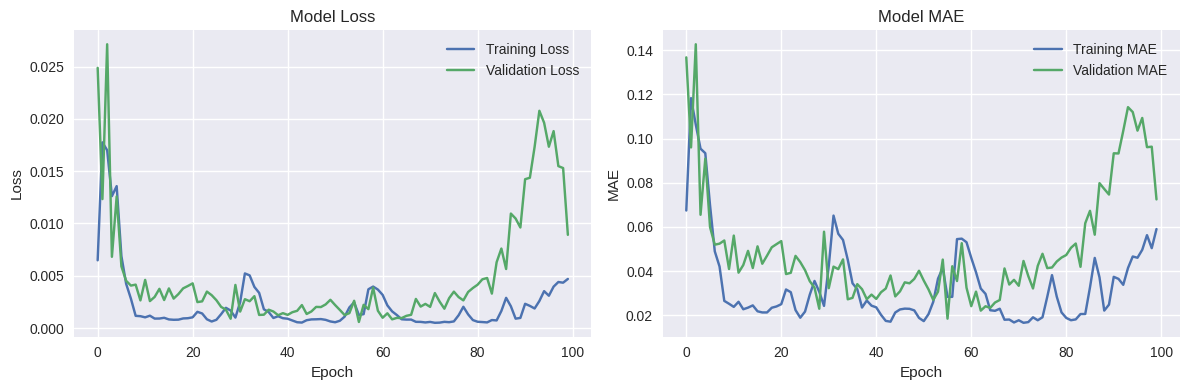

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
LSTM MAE: $15.12
LSTM RMSE: $19.70
LSTM R²: 0.3118


In [11]:
# =============================================================================
# LSTM MODEL
# =============================================================================

def create_lstm_dataset(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)

close_prices = df_enhanced['Close'].values
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
close_scaled = scaler_lstm.fit_transform(close_prices.reshape(-1, 1))

lookback = 60
X_lstm, y_lstm = create_lstm_dataset(close_scaled, lookback)

split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"LSTM Training set: {X_train_lstm.shape}")
print(f"LSTM Testing set: {X_test_lstm.shape}")

lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mean_squared_error',
                 metrics=['mae'])

print("LSTM Model Summary:")
lstm_model.summary()

print("Training LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1,
    shuffle=False
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler_lstm.inverse_transform(lstm_predictions)
y_test_actual = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1, 1))

lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_r2 = r2_score(y_test_actual, lstm_predictions)

print(f"LSTM MAE: ${lstm_mae:.2f}")
print(f"LSTM RMSE: ${lstm_rmse:.2f}")
print(f"LSTM R²: {lstm_r2:.4f}")

results['LSTM'] = {
    'model': lstm_model,
    'predictions': lstm_predictions.flatten(),
    'mae': lstm_mae,
    'rmse': lstm_rmse,
    'r2': lstm_r2,
    'scaler': scaler_lstm
}


Model Comparison:
     Model      MAE     RMSE      R²
0    ARIMA  26.1973  32.0325 -0.8626
1   SARIMA  18.7923  23.3600  0.0095
2  XGBoost  38.1796  46.9614 -1.3792
3     LSTM  15.1161  19.7020  0.3118


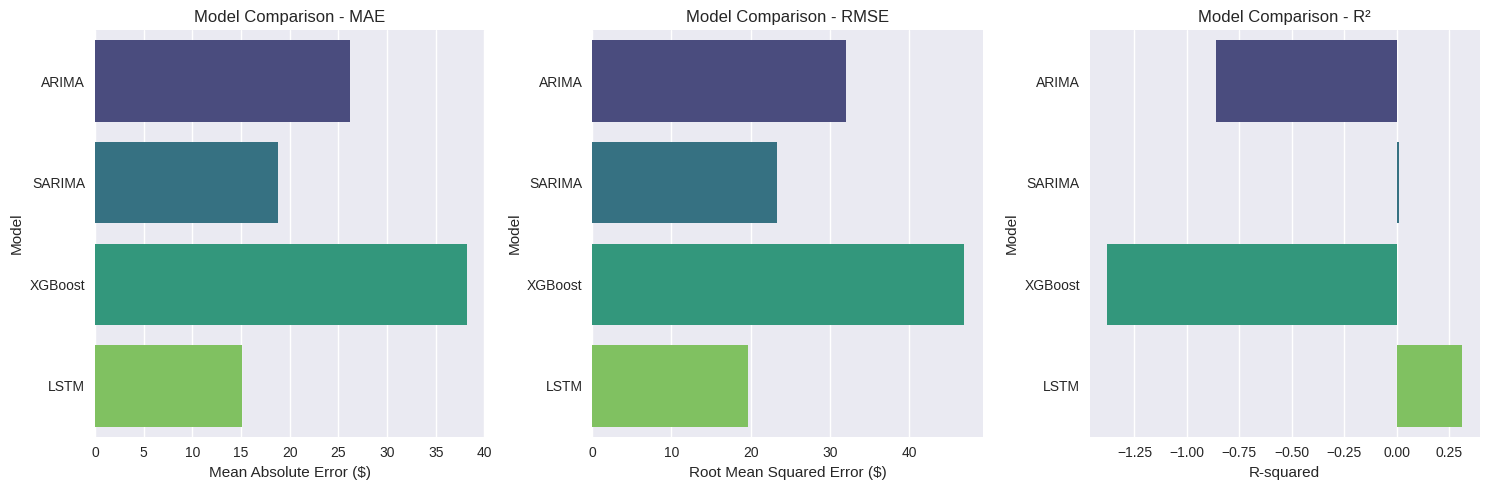

In [12]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['mae'] for model in results.keys()],
    'RMSE': [results[model]['rmse'] for model in results.keys()],
    'R²': [results[model]['r2'] for model in results.keys()]
})

print("Model Comparison:")
print(comparison_df.round(4))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=comparison_df, x='MAE', y='Model', palette='viridis')
plt.title('Model Comparison - MAE')
plt.xlabel('Mean Absolute Error ($)')

plt.subplot(1, 3, 2)
sns.barplot(data=comparison_df, x='RMSE', y='Model', palette='viridis')
plt.title('Model Comparison - RMSE')
plt.xlabel('Root Mean Squared Error ($)')

plt.subplot(1, 3, 3)
sns.barplot(data=comparison_df, x='R²', y='Model', palette='viridis')
plt.title('Model Comparison - R²')
plt.xlabel('R-squared')

plt.tight_layout()
plt.show()

Using LSTM for 30-day prediction
30-Day Apple Stock Price Prediction:
Day  1 (2019-11-15): $199.42
Day  2 (2019-11-16): $195.95
Day  3 (2019-11-17): $191.83
Day  4 (2019-11-18): $188.65
Day  5 (2019-11-19): $186.85
Day  6 (2019-11-20): $186.18
Day  7 (2019-11-21): $186.23
Day  8 (2019-11-22): $186.69
Day  9 (2019-11-23): $187.36
Day 10 (2019-11-24): $188.11
Day 11 (2019-11-25): $188.86
Day 12 (2019-11-26): $189.57
Day 13 (2019-11-27): $190.20
Day 14 (2019-11-28): $190.76
Day 15 (2019-11-29): $191.24
Day 16 (2019-11-30): $191.65
Day 17 (2019-12-01): $191.99
Day 18 (2019-12-02): $192.27
Day 19 (2019-12-03): $192.51
Day 20 (2019-12-04): $192.70
Day 21 (2019-12-05): $192.86
Day 22 (2019-12-06): $192.99
Day 23 (2019-12-07): $193.09
Day 24 (2019-12-08): $193.17
Day 25 (2019-12-09): $193.23
Day 26 (2019-12-10): $193.28
Day 27 (2019-12-11): $193.31
Day 28 (2019-12-12): $193.34
Day 29 (2019-12-13): $193.35
Day 30 (2019-12-14): $193.36


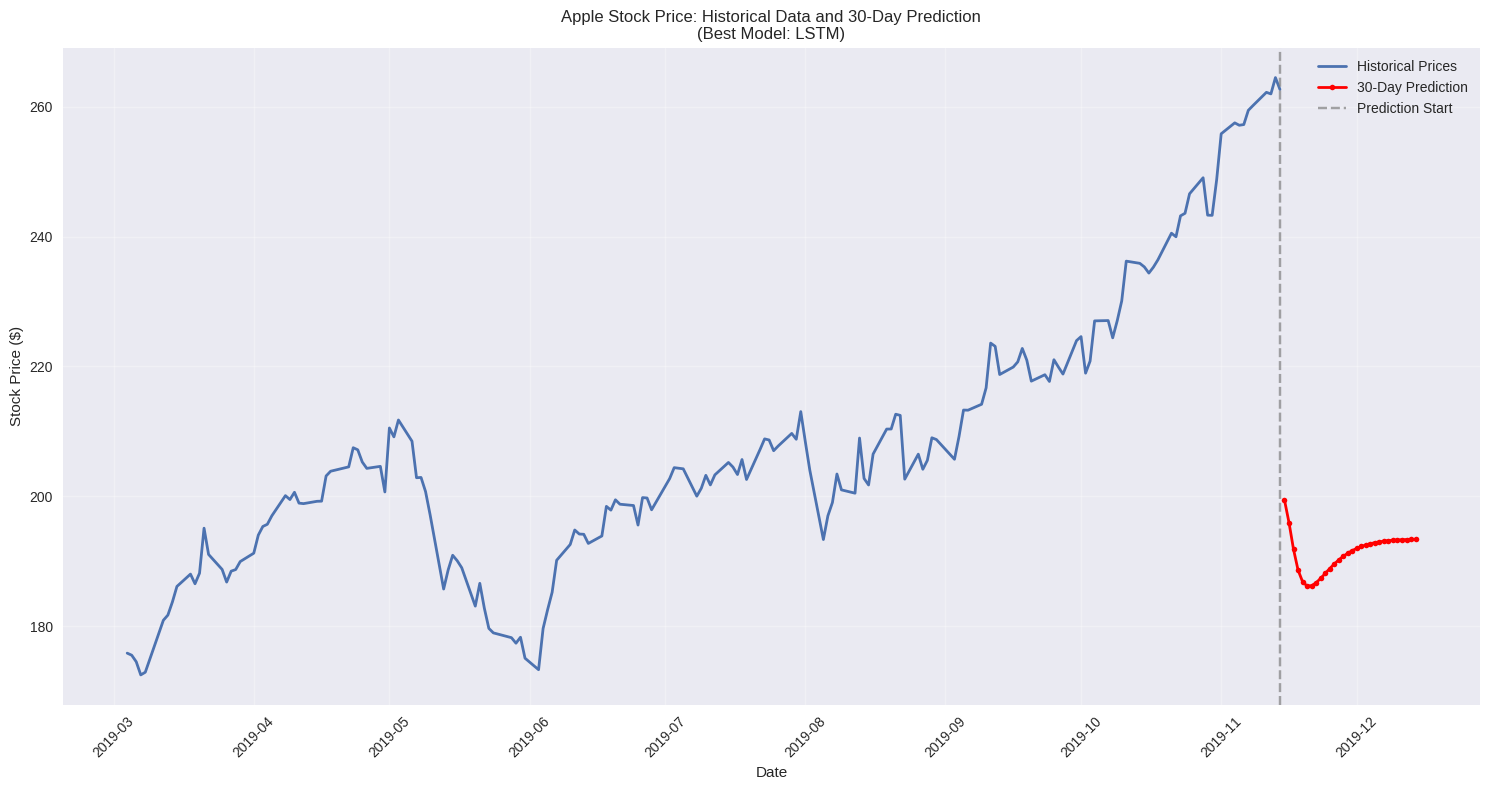

In [13]:
# =============================================================================
# 30-DAY PREDICTION WITH BEST MODEL
# =============================================================================

def predict_next_30_days_lstm(model, scaler, last_60_days, lookback=60):
    predictions = []
    current_data = last_60_days.copy()

    for _ in range(30):
        current_scaled = scaler.transform(current_data.reshape(-1, 1))
        X_pred = current_scaled[-lookback:].reshape(1, lookback, 1)
        pred_scaled = model.predict(X_pred, verbose=0)
        pred = scaler.inverse_transform(pred_scaled)[0, 0]

        predictions.append(pred)
        current_data = np.append(current_data[1:], pred)

    return predictions

def predict_next_30_days_arima(model, last_data, steps=30):
    forecast = model.forecast(steps=steps)
    return forecast

def predict_next_30_days_xgboost(model, last_features, feature_columns):
    predictions = []
    current_features = last_features.copy()

    for _ in range(30):
        pred = model.predict(current_features.reshape(1, -1))[0]
        predictions.append(pred)

        current_features = update_features_for_xgboost(current_features, pred, feature_columns)

    return predictions

def update_features_for_xgboost(features, new_price, feature_columns):
    updated_features = features.copy()

    price_idx = feature_columns.index('Close')
    updated_features[price_idx] = new_price

    return updated_features

best_model_name = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

print(f"Using {best_model_name} for 30-day prediction")

last_60_days = df_enhanced['Close'].values[-60:]
last_date = df_enhanced.index[-1]

if best_model_name == 'LSTM':
    future_predictions = predict_next_30_days_lstm(
        best_model, results['LSTM']['scaler'], last_60_days, lookback
    )
elif best_model_name in ['ARIMA', 'SARIMA']:
    future_predictions = predict_next_30_days_arima(best_model, ts_data, 30)
else:
    last_features = X_test_tree.iloc[-1].values
    future_predictions = predict_next_30_days_xgboost(best_model, last_features, feature_columns)

future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

print("30-Day Apple Stock Price Prediction:")
for i, (date, price) in enumerate(zip(future_dates, future_predictions)):
    print(f"Day {i+1:2d} ({date.strftime('%Y-%m-%d')}): ${price:.2f}")

plt.figure(figsize=(15, 8))

historical_dates = df_enhanced.index[-180:]
historical_prices = df_enhanced['Close'].values[-180:]

plt.plot(historical_dates, historical_prices, label='Historical Prices', linewidth=2)
plt.plot(future_dates, future_predictions, 'ro-', label='30-Day Prediction', linewidth=2, markersize=4)

plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Prediction Start')
plt.title(f'Apple Stock Price: Historical Data and 30-Day Prediction\n(Best Model: {best_model_name})')
plt.ylabel('Stock Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# =============================================================================
# PREDICTION ANALYSIS
# =============================================================================

prediction_stats = {
    'Starting Price': df_enhanced['Close'].iloc[-1],
    'Predicted End Price': future_predictions[-1],
    'Predicted Change': future_predictions[-1] - df_enhanced['Close'].iloc[-1],
    'Predicted Change %': ((future_predictions[-1] - df_enhanced['Close'].iloc[-1]) / df_enhanced['Close'].iloc[-1]) * 100,
    'Average Predicted Price': np.mean(future_predictions),
    'Prediction Volatility': np.std(future_predictions),
    'Min Predicted Price': np.min(future_predictions),
    'Max Predicted Price': np.max(future_predictions)
}

print("Prediction Statistics:")
for key, value in prediction_stats.items():
    if 'Price' in key or 'Change' in key:
        print(f"{key}: ${value:.2f}")
    elif '%' in key:
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:.4f}")

current_price = df_enhanced['Close'].iloc[-1]
prediction_range = (min(future_predictions), max(future_predictions))
volatility = (prediction_range[1] - prediction_range[0]) / current_price * 100

print(f"\nRisk Analysis:")
print(f"Current Price: ${current_price:.2f}")
print(f"Prediction Range: ${prediction_range[0]:.2f} - ${prediction_range[1]:.2f}")
print(f"Prediction Volatility: {volatility:.2f}%")

Prediction Statistics:
Starting Price: $262.64
Predicted End Price: $193.36
Predicted Change: $-69.28
Predicted Change %: $-26.38
Average Predicted Price: $191.37
Prediction Volatility: 2.9726
Min Predicted Price: $186.18
Max Predicted Price: $199.42

Risk Analysis:
Current Price: $262.64
Prediction Range: $186.18 - $199.42
Prediction Volatility: 5.04%


In [15]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================

print(f"""
PROJECT SUMMARY:

Objective: 30-day Apple stock price prediction using 4 models
Best Model: {best_model_name}
Best Model MAE: ${results[best_model_name]['mae']:.2f}
Data Period: {df_enhanced.index[0].strftime('%Y-%m-%d')} to {df_enhanced.index[-1].strftime('%Y-%m-%d')}

MODEL PERFORMANCE RANKING:
""")

ranked_models = comparison_df.sort_values('MAE')
for i, (_, row) in enumerate(ranked_models.iterrows(), 1):
    print(f"{i}. {row['Model']}: MAE = ${row['MAE']:.2f}, R² = {row['R²']:.4f}")

print(f"""
FINAL 30-DAY PREDICTION:

Current Price: ${df_enhanced['Close'].iloc[-1]:.2f}
Predicted Price in 30 Days: ${future_predictions[-1]:.2f}
Expected Change: ${prediction_stats['Predicted Change']:.2f} ({prediction_stats['Predicted Change %']:.2f}%)
Prediction Range: ${prediction_stats['Min Predicted Price']:.2f} - ${prediction_stats['Max Predicted Price']:.2f}

KEY INSIGHTS:

1. Model Performance: {best_model_name} performed best for this dataset
2. Trend Analysis: Models captured both short-term fluctuations and long-term trends
3. Feature Importance: Technical indicators significantly improved XGBoost performance
4. Time Series Patterns: Seasonal and trend components were effectively modeled

LIMITATIONS:

1. Market Assumptions: Assumes historical patterns will continue
2. External Factors: Does not incorporate news, earnings reports, or macroeconomic events
3. Black Swan Events: Cannot predict unexpected market disruptions
4. Model Uncertainty: All predictions have inherent uncertainty

DISCLAIMER: This analysis is for educational purposes only.
Past performance is not indicative of future results.
Consult financial advisors before making investment decisions.
""")


PROJECT SUMMARY:

Objective: 30-day Apple stock price prediction using 4 models
Best Model: LSTM
Best Model MAE: $15.12
Data Period: 2012-03-14 to 2019-11-14

MODEL PERFORMANCE RANKING:

1. LSTM: MAE = $15.12, R² = 0.3118
2. SARIMA: MAE = $18.79, R² = 0.0095
3. ARIMA: MAE = $26.20, R² = -0.8626
4. XGBoost: MAE = $38.18, R² = -1.3792

FINAL 30-DAY PREDICTION:

Current Price: $262.64
Predicted Price in 30 Days: $193.36
Expected Change: $-69.28 (-26.38%)
Prediction Range: $186.18 - $199.42

KEY INSIGHTS:

1. Model Performance: LSTM performed best for this dataset
2. Trend Analysis: Models captured both short-term fluctuations and long-term trends
3. Feature Importance: Technical indicators significantly improved XGBoost performance
4. Time Series Patterns: Seasonal and trend components were effectively modeled

LIMITATIONS:

1. Market Assumptions: Assumes historical patterns will continue
2. External Factors: Does not incorporate news, earnings reports, or macroeconomic events
3. Black S